## Workbook of tonal harmony
#### Analysis of the chorale BWV272 from the JS Bach's corpus in music21

In [1]:
from pcsPy import *
import pickle, copy
from IPython.display import Image 

<IPython.core.display.Javascript object>

Here we import the tonal model we are going to use for the analysis. A tonal model is the matrix of all the operators that connect the chords of a chord library as roman numerals.
Typical models are built using combinations of basic chord symbols and possible extension. 

Use tonalHarmonyModel.py to generate or modify models

In [2]:
f = open('../tonal.harmony.minimal','rb')
head = pickle.load(f)
table = pickle.load(f)
f.close()
tab = np.array(table)

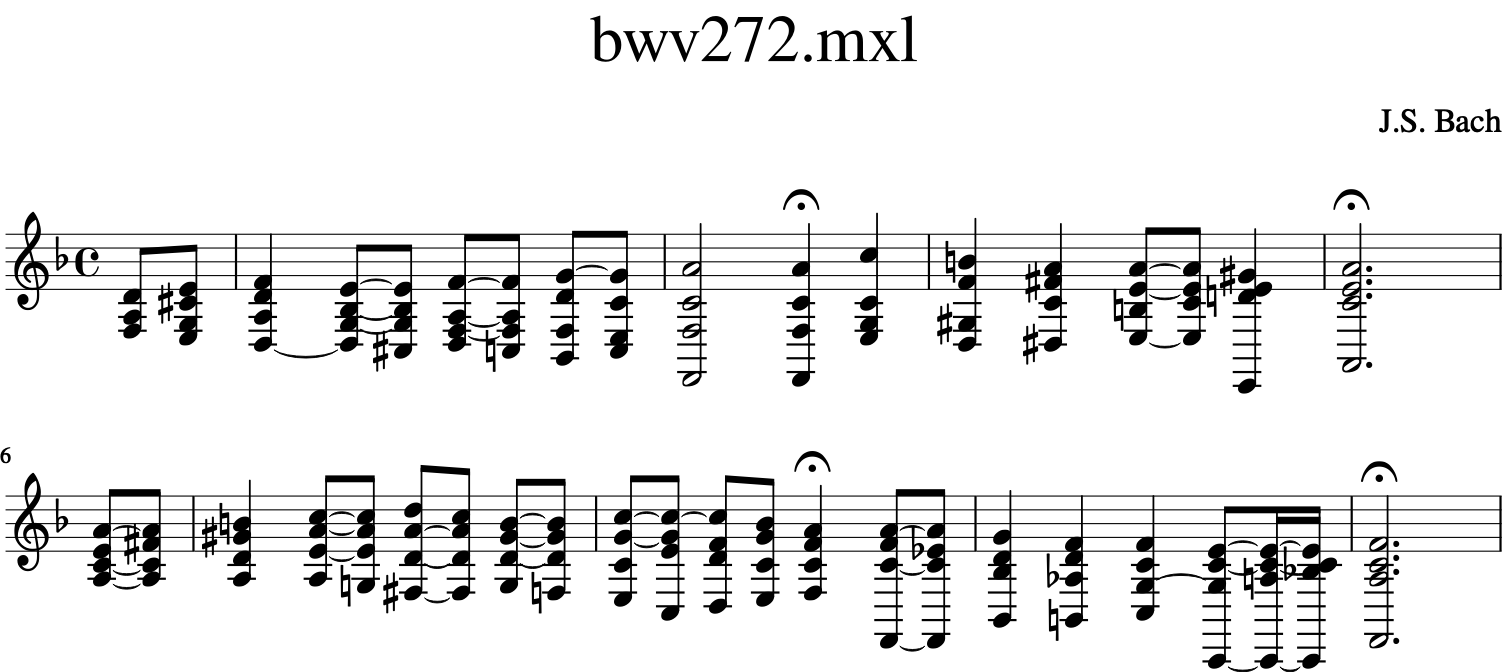

In [3]:
bachChorale = m21.corpus.parse('bwv272').corpusFilepath
seq,chords = readScore(bachChorale,music21=True,show=True)

In [ ]:
# To write chords and corresponding operators - uses musescore
WRITEscoreOps(seq,w=True)

In [4]:
# subtract grace note from chord for easier interpretation
seq[60] = [2,5,9]

In [39]:
dnodes,dedges,dcounts,deg,modul,Gx,Gxu = scoreNetwork(seq,ntx=True,general=True)
print('average degree = ',deg,' modularity = ',modul)
# Write to csv for visualization in Gephi or other network drawing software (see figure below)
# dnodes.to_csv('nodesbwv272.csv')
# dedges.to_csv('edgesbwv272.csv')
# Get modularity scores
part = cm.best_partition(Gxu) #,resolution=0.4)

average degree =  1.65625  modularity =  0.4879216992919616


## ![title](bwv272.png)

In [40]:
dn = np.array(dnodes)
labe = []
modu = []
modul = []
for m in range(len(dn)):
    labe.append(str(dn[m][0]))
    modu.append(part[str(m)])
    modul.append([str(dn[m][0]),Gx.degree()[str(m)],part[str(m)]])
modul = pd.DataFrame(modul,columns=['Label','Degree','Modularity'])
moduldict = dict(zip(labe,modu))

In [7]:
# display the score with modularity classes
mc = []
seqmc = []
for n in range(len(seq)):
    p = PCSet(np.asarray(seq[n]))
    nn = ''.join(m21.chord.Chord(p.normalOrder().tolist()).pitchNames)
    mc.append(nn)
    seqmc.append(moduldict[nn])

In [8]:
l = 0
analyzed = copy.deepcopy(chords)
for c in analyzed.recurse().getElementsByClass('Chord'):
    c.closedPosition(forceOctave=4,inPlace=True)
    c.addLyric(str(l))
    c.addLyric(seqmc[l])
    l += 1
analyzed.show('musicxml')

In [ ]:
modul.to_csv('~/Desktop/modul.csv')

In [46]:
modul[['Label','Degree','Modularity']].query('Modularity == 2').sort_values(by=['Degree'],ascending=False)

,Label,Degree,Modularity
20,DFG#B,8,2
0,ABE,2,2
3,ACE-F,2,2
10,CE-F#A,2,2
28,FGC,2,2
30,GB-D,2,2


In [53]:
# Dictionary of modularity classes and relative keys
keydict = {0:'D', 1:'F', 2:'C', 3:'A', 4:'A', 5:'A'}

In [ ]:
# moduldict['B-CE'] = 2
# moduldict['C#EG'] = 3
# print(moduldict)

In [27]:
# Dictionary of nomenclature for notes in music21 Chords
idx = []
notes = []
for n in range(60,84):
    no = m21.note.Note(n).nameWithOctave
    if no == 'G#4': no = 'A-4'
    if no == 'G#5': no = 'A-5'
    if no == 'A#4': no = 'B-4'
    if no == 'A#5': no = 'B-5'
    notes.append(no)
    idx.append(n)
notedict = dict(zip(idx, notes))

In [12]:
# Determination of operators
try:
    ntot = seq.shape[0]
except:
    ntot = len(seq)
ops = []
for i in range(ntot):
    if i < ntot-1: 
        ops.append(generalizedOpsName(seq[i],seq[i+1])[1])

In [124]:
# Score analysis
verbose = False
# First chord
rn = []
ch = np.copy(seq[0])
for n in range(1,len(ch)):
    if ch[n] < ch[n-1]: ch[n] += 12
ch += 60
n = m21.chord.Chord(ch.tolist())
chord = ''.join(n.pitchNames)
key = keydict[moduldict[chord]] 
rn.append(m21.roman.romanNumeralFromChord(n, m21.key.Key(key)).figure)
# Full score
nx = ntot-1
i = 0
check = 0
while i < nx:   
    try:
        if i == 110000:
            rn.append(' ')
        elif i == 48000:
            rn.append(' ')
        else:
            idx,idy = np.where(tab == ops[i])
            tmp = []
            for n in range(len(idy)):
                if (rn[i] == str(head[idx[n]])):
                    tmp.append(head[idy[n]])
            if len(tmp) == 1:
                rn.append(tmp[0])
            else:
                chord = ''.join(m21.chord.Chord(PCSet(seq[i]).normalOrder().tolist()).pitchNames)
                key = keydict[moduldict[chord]]
                for n in range(len(tmp)):
                    ch = m21.roman.RomanNumeral(tmp[n],m21.key.Key(key)).pitchClasses
                    if PCSet(ch).normalOrder().tolist() == seq[i+1]:
                        rn.append(str(tmp[n]))
                        break
        i += 1
    except:
        try:
            if check == i:
                break
            else:
                print('modulation at or before chord no. ',i)
                check = i
#                 print(rn[i-1])
                rn.pop()
                ch = np.copy(PCSet(seq[i-1]).normalOrder().tolist())
                for n in range(1,len(ch)):
                    if ch[n] < ch[n-1]: ch[n] += 12
                ch += 60
                p = []
                for c in ch:
                    p.append(notedict[c])
                n = m21.chord.Chord(p)
                chord = ''.join(n.pitchNames)
                m = m21.chord.Chord(ch.tolist())
                try:
                    key = keydict[moduldict[''.join(m.pitchNames)]] 
                    if i == 39: key = 'F'
                    if i == 50: key = 'G#'
                    if i == 51: key = 'G#'
                    if i == 52: key = 'F'
                    if verbose: print(n.chordTablesAddress,n,key)
                    rn.append(m21.roman.romanNumeralFromChord(n, m21.key.Key(key)).figure)
                    if rn[i-1] == 'V65': rn[i-1] = 'V7'
                    if rn[i-1] == 'V42': rn[i-1] = 'V7[no5]'
                    if rn[i-1] == 'I42': rn[i-1] = 'I7[no5]'
                    if rn[i-1] == 'II65': rn[i-1] = 'II7'
                    if rn[i-1] == 'viio6b5': rn[i-1] = 'viio7'
                    if rn[i-1] == 'ivo5b3': rn[i-1] = 'ivo'
                    if rn[i-1] == 'bI6b5': rn[i-1] = 'VII7'
                    i -= 1
                except Exception as e:
                    print(type(e))
                    print(e.args)
                    print(e) 
                    print(chord)
                    break
        except Exception as e:
            print(type(e)) 
            break
nx = i

modulation at or before chord no.  6
modulation at or before chord no.  7
modulation at or before chord no.  13
modulation at or before chord no.  19
modulation at or before chord no.  31
modulation at or before chord no.  35
modulation at or before chord no.  39
modulation at or before chord no.  50
modulation at or before chord no.  52


In [ ]:
print(rn[49])
ch = np.copy(PCSet(seq[49]).normalOrder().tolist())
print(ch)
for n in range(1,len(ch)):
    if ch[n] < ch[n-1]: ch[n] += 12
ch += 60
print(ch)
p = []
for c in ch:
    p.append(notedict[c])
print(p)
n = m21.chord.Chord(p)
print(n.chordTablesAddress)
print(n)
print(m21.roman.romanNumeralFromChord(n, m21.key.Key('G#')).figure)

In [ ]:
# Score analysis
# First chord
rn = []
ch = np.copy(seq[0])
for n in range(1,len(ch)):
    if ch[n] < ch[n-1]: ch[n] += 12
ch += 60
n = m21.chord.Chord(ch.tolist())
chord = ''.join(n.pitchNames)
key = keydict[moduldict[chord]] 
rn.append(m21.roman.romanNumeralFromChord(n, m21.key.Key(key)).figure)
# Full score
nx = ntot-1
for i in range(nx):
    try:
        # these are the modulations
        if i == 4:
            rn.append('i')
        elif i == 5:
            rn.append('I')
        elif i == 10:
            rn.append('I')
        elif i == 11:
            rn.append('viio7')
        elif i == 17:
            rn.append('i')
        else:
            idx,idy = np.where(tab == ops[i])
            tmp = []
            for n in range(len(idy)):
                if (rn[i] == str(head[idx[n]])):
                    tmp.append(head[idy[n]])
            if len(tmp) == 1:
                rn.append(tmp[0])
            else:
                chord = ''.join(m21.chord.Chord(PCSet(seq[i]).normalOrder().tolist()).pitchNames)
                key = keydict[moduldict[chord]]
                for n in range(len(tmp)):
                    ch = m21.roman.RomanNumeral(tmp[n],m21.key.Key(key)).pitchClasses
                    if PCSet(ch).normalOrder().tolist() == seq[i+1]:
                        rn.append(str(tmp[n]))
                        break
    except Exception as e:
        print('check at or before chord no. ',i,' for possible modulation')
        print(type(e),e)
        nx = i
        break

In [125]:
# Create dictionary of score analysis
reference = []
for n in range(nx):
    try:
        chord = ''.join(m21.chord.Chord(PCSet(seq[n]).normalOrder().tolist()).pitchNames)
        entry = [PCSet(seq[n]).normalOrder(),chord,rn[n],ops[n],keydict[moduldict[chord]],moduldict[chord]]
        reference.append(entry)
    except:
        pass

In [126]:
# Add last chord
ops.append(' ')
chord = ''.join(m21.chord.Chord(PCSet(seq[nx]).normalOrder().tolist()).pitchNames)
entry = [PCSet(seq[nx]).normalOrder(),chord,rn[nx],ops[nx],keydict[moduldict[chord]]]
reference.append(entry)

In [127]:
# Set dictionary as pandas dataframe
analysis = pd.DataFrame(reference,columns=['pcs','chord','rn','ops','key','modul'])

In [128]:
analysis

,pcs,chord,rn,ops,key,modul
0,"[2, 5, 9]",DFA,i,"O(-1,-1,-2)",D,0.0
1,"[1, 4, 7]",C#EG,viio,"O(1,1,2)",D,0.0
2,"[2, 5, 9]",DFA,i,"O(2,1,0,-1)",D,0.0
3,"[2, 4, 7, 10]",DEGB-,ii/o7,"O(-1,0,0,0)",D,0.0
4,"[1, 4, 7, 10]",C#EGA#,iio7,"O(1,1,-2,-1)",D,0.0
...,...,...,...,...,...,...
60,"[2, 5, 9]",DFA,i,"O(0,-1,0)",D,0.0
61,"[2, 4, 9]",DEA,i52,"O(-1,0,0)",D,0.0
62,"[9, 1, 4]",AC#E,V,"O(0,0,0,-2)",D,0.0
63,"[1, 4, 7, 9]",C#EGA,V7,"O(1,1,-2,0)",D,0.0


In [129]:
analysis.to_csv('bwv272.csv')

In [ ]:
# display the analyzed score
l = 0
analyzed = copy.deepcopy(chords)
for c in analyzed.recurse().getElementsByClass('Chord'):
    c.addLyric('')
    c.addLyric('')
    c.addLyric(str(ops[l]))
    c.addLyric(str(rn[l]))
    l += 1
analyzed.show('musicxml')

In [ ]:
seq[49],ops[49],seq[50]

In [ ]:
seq[59],ops[59],seq[60]